In [1]:
!pip install --upgrade plotly plotnine

!pip install fastinference

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 66.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 61.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.22.0
    Uninstalling plotly-5.22.0:
      Successfully uninstalled plotly-5.22.0
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.5
    Uninstalling matplotlib-3.7.5:
      Successfully uninstalled matplotlib-3.7.5
  Attempting uninstall: mizani
    Found existing installation: mizani 0.11.4
    Uninstalling mizani-0.11.4:
      Successfully uninstalled mizani-0.11.4
  Attempting uninstall: plotnine
    Found existing installation: plotnine 0.13.6
    Uninstalling plotnine-0.13.6:
      Successfully uninstalled plotnine-0.13.6
ERROR: pip's dependency 

In [2]:
import os

import pickle

import random

import warnings

import numpy as np

import pandas as pd

import seaborn as sns

from tqdm import tqdm

from fastai.tabular.all import * 

# from fastinference.tabular import *

from sklearn.model_selection import GroupKFold

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from sklearn.preprocessing import LabelEncoder, StandardScaler, SplineTransformer





import torch

import torch.nn as nn

import torch.optim as optim

import torch.nn.functional as F

from torch.optim import Adam, SGD

from torch.autograd import Variable

from torch.utils.data import TensorDataset, DataLoader,Dataset

from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts



warnings.simplefilter("ignore")

In [3]:
def periodic_spline_transformer(period, n_splines=None, degree=3):

    if n_splines is None:

        n_splines = period

    n_knots = n_splines + 1  # periodic and include_bias is True

    return SplineTransformer(

        degree=degree,

        n_knots=n_knots,

        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),

        extrapolation="periodic",

        include_bias=True)



def seed_everything(seed=42):

    random.seed(seed)

    os.environ['PYTHONHASHSEED'] = str(seed)

#     os.environ['CUDA_LAUNCH_BLOCKING'] = str(1)

    np.random.seed(seed)

    torch.manual_seed(seed)

    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.deterministic = True



set_seed(42)

seed_everything(seed=42)

In [4]:
set_seed(42)

seed_everything(seed=42)


df_total = pd.read_csv("/kaggle/input/5g-project-data/ECdata.csv",parse_dates=['Time'])

# df_train = pd.read_csv("/kaggle/input/ecm-itu-zindi-kp-data/imgs_2023071012133740345.csv",parse_dates=['Time'])

# df_test = pd.read_csv("/kaggle/input/ecm-itu-zindi-kp-data/imgs_202307101549519358.csv",parse_dates=['Time'])

df_cell = pd.read_csv("/kaggle/input/5g-project-data/CLdata.csv",parse_dates=['Time'])

df_bs = pd.read_csv("/kaggle/input/5g-project-data/BSinfo.csv")

df_features = df_cell.merge(df_bs,on=['BS','CellName'],how='outer')

df_features = df_features[df_features['CellName']=='Cell0'].reset_index(drop=True)

# df_test['split'] = 'test'

# df_train['split'] = 'train'

# df_total = pd.concat([df_train,df_test],ignore_index=True)

df_total = df_total.merge(df_features,on=['BS','Time'],how='left')

df_total['ID'] = df_total['Time'].astype(str)+"_"+df_total['BS']

df_total['BS'] = df_total['BS'].str.replace(r'[a-zA-Z_]', '', regex=True).astype(int)

for col in ['RUType','Mode']:

    df_total[col] = df_total[col].str.replace(r'[a-zA-Z]', '', regex=True).astype(int)



df_total.sort_values(['BS','Time'], ascending=True,ignore_index=True,inplace=True)

df_total['day'] = df_total['Time'].dt.day

df_total['weekday_number'] = df_total['Time'].dt.weekday

df_total['hour'] = df_total['Time'].dt.hour



hour_df = df_total[['hour']].copy()

splines = periodic_spline_transformer(24, n_splines=12).fit_transform(hour_df)

splines_df = pd.DataFrame(splines,columns=[f"hour_spline_{i}" for i in range(splines.shape[1])])

df_total = pd.concat([df_total,splines_df],axis=1)



df_total = df_total.sort_values(['BS','Time'],ascending=True,ignore_index=True)

all_shits = list(np.arange(1,4)) # 

for shift_i in tqdm(all_shits):

    for col in ['load','ESMode1','ESMode2','ESMode3','ESMode6','Time','Energy']:

        df_total[f'{col}_T-{shift_i}'] = df_total.groupby(['BS'])[col].shift(shift_i)        

for shift_i in tqdm(all_shits):

    df_total[f'Time_T-{shift_i}_hours_elapsed'] = (df_total[f'Time_T-{shift_i}']-df_total['Time']).dt.total_seconds() / 3600

    del df_total[f'Time_T-{shift_i}']

print(df_total.shape)



num_bins = 100

df_total['load_bin'] = pd.cut(df_total['load'],bins=[round(i,2) for i in list(np.arange(0,1.01,0.01))],labels=[f'{i}' for i in range(num_bins)])

df_total['load_bin'] = df_total['load_bin'].astype(float).fillna(-1).astype(int)



print(df_total.shape)


100%|██████████| 3/3 [00:00<00:00, 268.69it/s]

(92629, 54)
(92629, 55)


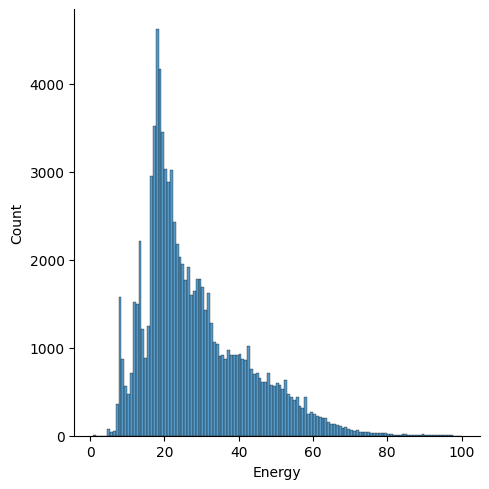

In [5]:
sns.displot(df_total['Energy'])

<Axes: xlabel='Time'>

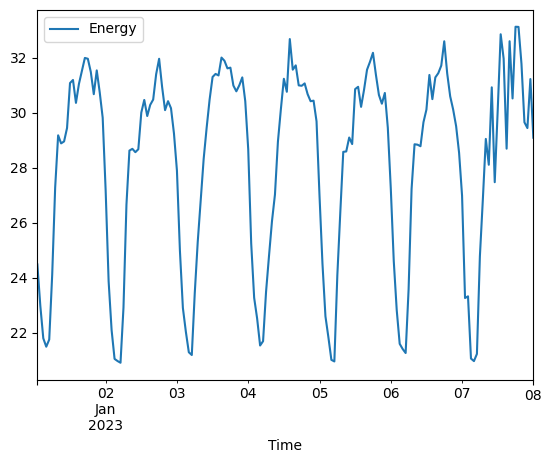

In [6]:
df_total.groupby(['Time'])[['Energy']].mean().plot()

<Axes: xlabel='load'>

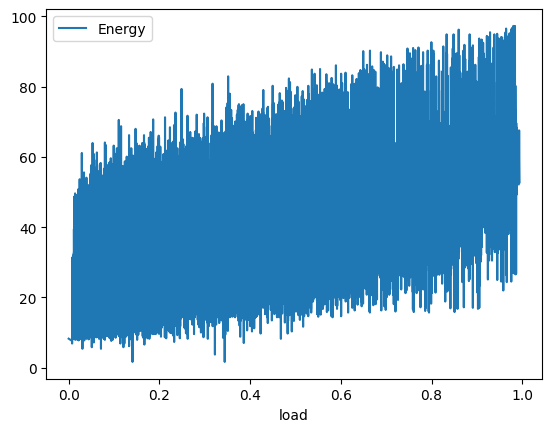

In [7]:
df_total.groupby(['load'])[["Energy"]].mean().plot()

In [11]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.signal import savgol_filter as sg
from scipy.signal import sosfiltfilt, butter, sosfilt, sosfilt_zi

# Seed setting functions (for reproducibility)
def set_seed(seed):
    np.random.seed(seed)
    import random
    random.seed(seed)
    import torch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    import tensorflow as tf
    tf.random.set_seed(seed)

def seed_everything(seed=42):
    set_seed(seed)
    print(f"Seed set to {seed}")

# Call the function to set seed
set_seed(42)
seed_everything(42)

# Savitzky-Golay Filter function
def add_sg(df):
    w = 5  # Window length
    p = 3  # Polynomial order

    for si in tqdm(df.BS.unique()):
        index = df.BS == si

        # Ensure window size does not exceed the size of the data
        group_size = len(df.loc[index, 'load'])
        if group_size >= w:
            df.loc[index, 'load_smooth'] = sg(df.loc[index, 'load'], w, p)
            df.loc[index, 'load_diff'] = sg(df.loc[index, 'load'], w, p, 1)
            df.loc[index, 'load_diff2'] = sg(df.loc[index, 'load'], w, p, 2)
            df.loc[index, 'load_diff3'] = sg(df.loc[index, 'load'], w, p, 3)
        else:
            print(f"Skipping BS {si} because its data length ({group_size}) is smaller than window length {w}.")

# Apply the Savitzky-Golay filter
add_sg(df_total)
print(df_total.shape)

# SOS Filter function
def add_sosfiltfilt(df):
    for si in tqdm(df.BS.unique()):
        index = df.BS == si

        # Check the length of the data for this group
        group_size = len(df.loc[index, 'load'])
        
        # Skip groups with insufficient data for filtering
        if group_size > 15:
            # Define the filter coefficients
            sos = butter(4, 0.125, output='sos')  # 4th order low-pass filter
            sos8 = butter(8, 0.125, output='sos')  # 8th order low-pass filter

            # Apply sosfiltfilt (which handles initial conditions automatically)
            df.loc[index, 'load_sosfiltfilt'] = sosfiltfilt(sos, df.loc[index, 'load'])

            # Apply sosfilt with initial condition using sos8
            zi = np.array(df.loc[index, 'load'][:4]).mean() * sosfilt_zi(sos8)  # Calculate initial condition
            df.loc[index, 'load_sosfilt'], _ = sosfilt(sos8, df.loc[index, 'load'], zi=zi)
        else:
            print(f"Skipping BS {si} because its data length ({group_size}) is smaller than required for filtering.")

# Apply the SOS filter
add_sosfiltfilt(df_total)
print(df_total.shape)


Seed set to 42


 94%|█████████▎| 865/923 [00:04<00:00, 180.61it/s]

Skipping BS 835 because its data length (1) is smaller than window length 5.
Skipping BS 854 because its data length (1) is smaller than window length 5.


100%|██████████| 923/923 [00:05<00:00, 173.31it/s]


(92629, 61)


 93%|█████████▎| 860/923 [00:04<00:00, 206.20it/s]

Skipping BS 835 because its data length (1) is smaller than required for filtering.
Skipping BS 854 because its data length (1) is smaller than required for filtering.
Skipping BS 905 because its data length (13) is smaller than required for filtering.
Skipping BS 921 because its data length (14) is smaller than required for filtering.


100%|██████████| 923/923 [00:04<00:00, 201.49it/s]

(92629, 61)


In [13]:
X = df_total.drop('Energy', axis=1)
y = df_total['Energy']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [14]:
set_seed(42)

seed_everything(seed=42)



df_total.drop(columns=['CellName','ESMode4','Time'],inplace=True)



id_variable = 'ID'

version_nb = 'v4'

TARGET = 'Energy'



# train_df = df_total[df_total['split']=='train'].reset_index(drop=True)

# test_df = df_total[df_total['split']=='test'].reset_index(drop=True)

train_cols = [i for i in train_df if i not in ['Time','CellName','ID','Energy','split','w','BS','ESMode6']]



categorical_cols = ['RUType','Mode','load_bin']



print(train_df[train_cols].shape, test_df[train_cols].shape)

Seed set to 42
(62061, 55) (30568, 55)


In [15]:
set_seed(42)

seed_everything(seed=42)



remove_non_unique_cols = []

print('train single values ..')

for col in train_df:

    if col in train_cols and col not in ['ESMode5']:

        if train_df[col].nunique()<=1:

            remove_non_unique_cols.append(col)

            print(col,":",train_df[col].nunique())

print('test single values ..')

for col in test_df:

    if col in train_cols and col not in ['ESMode5']:

        if test_df[col].nunique()<=1:

            remove_non_unique_cols.append(col)

            print(col,":",test_df[col].nunique())



print('\n',remove_non_unique_cols)



for col in train_df:

    if col in train_cols:

        if train_df[col].isnull().sum()/len(train_df)>=0.95:

            print(col,":",train_df[col].isnull().sum()/len(train_df))

            remove_non_unique_cols.append(col)



for col in test_df:

    if col in train_cols:

        if test_df[col].isnull().sum()/len(test_df)>=0.95:

            print(col,":",test_df[col].isnull().sum()/len(test_df))

            remove_non_unique_cols.append(col)

            

print(len(train_cols))

train_cols = [col for col in train_cols if col not in remove_non_unique_cols]

print(len(train_cols))

print(train_cols)


Seed set to 42
train single values ..
ESMode4 : 1
test single values ..
ESMode4 : 1

 ['ESMode4', 'ESMode4']
55
54
['load', 'ESMode1', 'ESMode2', 'ESMode3', 'ESMode5', 'RUType', 'Mode', 'Frequency', 'Bandwidth', 'Antennas', 'TXpower', 'day', 'weekday_number', 'hour', 'hour_spline_0', 'hour_spline_1', 'hour_spline_2', 'hour_spline_3', 'hour_spline_4', 'hour_spline_5', 'hour_spline_6', 'hour_spline_7', 'hour_spline_8', 'hour_spline_9', 'hour_spline_10', 'hour_spline_11', 'load_T-1', 'ESMode1_T-1', 'ESMode2_T-1', 'ESMode3_T-1', 'ESMode6_T-1', 'Energy_T-1', 'load_T-2', 'ESMode1_T-2', 'ESMode2_T-2', 'ESMode3_T-2', 'ESMode6_T-2', 'Energy_T-2', 'load_T-3', 'ESMode1_T-3', 'ESMode2_T-3', 'ESMode3_T-3', 'ESMode6_T-3', 'Energy_T-3', 'Time_T-1_hours_elapsed', 'Time_T-2_hours_elapsed', 'Time_T-3_hours_elapsed', 'load_bin', 'load_smooth', 'load_diff', 'load_diff2', 'load_diff3', 'load_sosfiltfilt', 'load_sosfilt']


In [17]:
from sklearn.model_selection import GroupKFold

# Ensure that 'train_df' has an integer index (or reset it if needed)
train_df = train_df.reset_index(drop=True)

# Prepare the GroupKFold
Nfold = 10
train_df['fold'] = -1  # Initialize a new 'fold' column
strafy_bin = train_df['BS'].astype('int')  # Assuming 'BS' is the stratification column

skf = GroupKFold(n_splits=Nfold)

# GroupKFold split
for i, (_, train_index) in enumerate(skf.split(train_df, train_df, groups=strafy_bin)):
    train_df.iloc[train_index, train_df.columns.get_loc('fold')] = i  # Use iloc to set the fold

# Now train_df has a 'fold' column with fold numbers assigned to each row.


### FastAI model

In [19]:
set_seed(42)

seed_everything(seed=42)



def mae(preds, targs):

    x = (targs-preds)

    return (abs(x)).mean()



def mape(preds, targs):

    x = (targs-preds)/targs

    return (abs(x)).mean()



def fit_fastai(Nfolds, train_df, test_df, train_cols, cat_feats, TARGET, model_path):

    

    oof_pred_fastai = np.zeros(train_df.shape[0], dtype=np.float32)

    pred_fastai = np.zeros(test_df.shape[0], dtype=np.float32)

    scores = []

    scores_pvt = []

    

    train_df_fast = train_df[train_cols + [TARGET]].copy()

    test_df = test_df.copy()

    for col in train_df_fast.columns:

        if col not in cat_feats:

            train_df_fast[col] = train_df_fast[col].fillna(0)

            test_df[col] = test_df[col].fillna(0)

        else:

            # Impute missing categorical values with the most frequent category

            most_frequent_category = train_df_fast[col].mode().iloc[0]

            train_df_fast[col] = train_df_fast[col].fillna(most_frequent_category)

            test_df[col] = test_df[col].fillna(most_frequent_category)



    train_df_fast[cat_feats] = train_df_fast[cat_feats].astype('category')

    test_df[cat_feats] = test_df[cat_feats].astype('category')

    

    cont_nn = train_cols.copy()

    for col in cat_feats:

        cont_nn.remove(col)



    cat_nn = cat_feats



    layers =  [256, 512, 1024, 512, 256] #[256, 512, 1024, 512, 256]



    val_pct, tst_preds = L(), L()



    for fold in range(Nfolds):

        print("*"*10, f'Fold-{fold+1}', "*"*10)

        train_idx = train_df.loc[train_df['fold']!=fold, :].index

        valid_idx = train_df.loc[train_df['fold']==fold, :].index

        splits = (L(list(train_idx)), L(list(valid_idx)))

        dls = TabularPandas(train_df_fast, [Categorify, Normalize], cat_nn, cont_nn, splits = splits, y_names=TARGET,reduce_memory=False).dataloaders(1024)

        learn = tabular_learner(dls, layers=layers, n_out=1, y_range = (0,100),loss_func = mae, metrics=AccumMetric(mae))

#         print(learn.summary())

#         learn.lr_find(suggest_funcs=(slide, valley))

#         if os.path.isfile(model_path + f'models/nn_model_{fold}.pth'):

#             learn = tabular_learner(dls, layers=layers, n_out=1, path = model_path)

#             learn.load(f'nn_model_{fold}')

#         else:

        learn.fit_one_cycle(100, 2e-3, cbs=SaveModelCallback(monitor='mae', comp=np.less, fname=f'nn_model_{fold}'))



        val_df = train_df.loc[train_df['fold']==fold]

        val_dl = dls.test_dl(val_df[train_cols].fillna(0))

        

        preds, _ = learn.get_preds(dl=val_dl)

        oof_pred_fastai[val_df.index] = preds.squeeze().numpy()

       

        score = mean_absolute_error(val_df[TARGET], oof_pred_fastai[val_df.index])

        score_pvt = mean_absolute_percentage_error(val_df[TARGET], oof_pred_fastai[val_df.index])

        

        scores.append(score)

        scores_pvt.append(score_pvt)

        print(f'MAE for Fold-{fold+1}:', np.round(score, 3))

        print(f'MAPE for Fold-{fold+1}:', np.round(score_pvt, 3))

        

        test_dl = dls.test_dl(test_df[train_cols])

        preds, _ = learn.get_preds(dl=test_dl)

        pred_fastai += preds.squeeze().numpy()/Nfolds



#         display(test_df[train_cols].iloc[-5:])

        

#         exp = ShapInterpretation(learn, test_df[train_cols].iloc[-5:])

#         exp.summary_plot()





    score = mean_absolute_error(train_df[TARGET],oof_pred_fastai)

    score_pvt = mean_absolute_percentage_error(train_df[TARGET],oof_pred_fastai)

    

    print(f'OOF MAE:', np.round(score, 3))

    print(f'Average MAE:', f'{np.round(np.mean(scores), 3)}+/-{np.round(np.std(scores), 3)}')

    

    print(f'OOF MAPE:', np.round(score_pvt, 3))

    print(f'Average MAPE:', f'{np.round(np.mean(scores_pvt), 3)}+/-{np.round(np.std(scores_pvt), 3)}')



    return oof_pred_fastai, pred_fastai

Seed set to 42


In [20]:
set_seed(42)

seed_everything(seed=42)



if Inference:

    model_path = '../input/ecm-output-of-final-notebook/'

else:

    model_path = './'



oof_pred_fastai, pred_fastai = fit_fastai(Nfold, train_df, test_df, train_cols, categorical_cols, TARGET, model_path)



train_df = train_df.copy()

train_df['oof_fastai'] = oof_pred_fastai

Seed set to 42
********** Fold-1 **********


epoch,train_loss,valid_loss,mae,time
0,10.871793,6.981629,6.981629,00:01
1,7.674756,5.015224,5.015224,00:01
2,6.064980,4.211987,4.211987,00:01
3,5.069690,4.023963,4.023963,00:00
4,4.573433,3.565450,3.565450,00:00
5,3.912013,2.988676,2.988676,00:00
6,3.798877,3.523429,3.523428,00:00
7,3.842104,2.931347,2.931347,00:01
8,3.587103,2.927865,2.927865,00:01
9,3.281593,2.382771,2.382771,00:01


Better model found at epoch 0 with mae value: 6.981629371643066.
Better model found at epoch 1 with mae value: 5.015223503112793.
Better model found at epoch 2 with mae value: 4.211986541748047.
Better model found at epoch 3 with mae value: 4.023963451385498.
Better model found at epoch 4 with mae value: 3.5654501914978027.
Better model found at epoch 5 with mae value: 2.988676071166992.
Better model found at epoch 7 with mae value: 2.931346893310547.
Better model found at epoch 8 with mae value: 2.9278647899627686.
Better model found at epoch 9 with mae value: 2.382770538330078.
Better model found at epoch 11 with mae value: 2.3556385040283203.
Better model found at epoch 14 with mae value: 2.1418817043304443.
Better model found at epoch 15 with mae value: 1.7153517007827759.
Better model found at epoch 19 with mae value: 1.5818257331848145.
Better model found at epoch 21 with mae value: 1.2402467727661133.
Better model found at epoch 29 with mae value: 1.2295960187911987.
Better mode

MAE for Fold-1: 0.964
MAPE for Fold-1: 0.035


********** Fold-2 **********


epoch,train_loss,valid_loss,mae,time
0,11.755648,10.082140,10.082140,00:00
1,8.144567,7.153311,7.153311,00:00
2,6.098210,6.416761,6.416760,00:00
3,5.144058,5.043830,5.043830,00:00
4,4.571835,4.115295,4.115295,00:00
5,3.921026,4.232346,4.232346,00:00
6,3.802929,3.713941,3.713941,00:00
7,3.333535,2.755500,2.755499,00:00
8,3.149287,2.555913,2.555913,00:00
9,2.929458,2.403666,2.403666,00:00


Better model found at epoch 0 with mae value: 10.08213996887207.
Better model found at epoch 1 with mae value: 7.153310775756836.
Better model found at epoch 2 with mae value: 6.416760444641113.
Better model found at epoch 3 with mae value: 5.043830394744873.
Better model found at epoch 4 with mae value: 4.115294933319092.
Better model found at epoch 6 with mae value: 3.7139410972595215.
Better model found at epoch 7 with mae value: 2.7554988861083984.
Better model found at epoch 8 with mae value: 2.5559134483337402.
Better model found at epoch 9 with mae value: 2.403665542602539.
Better model found at epoch 10 with mae value: 2.2910640239715576.
Better model found at epoch 13 with mae value: 2.1742188930511475.
Better model found at epoch 14 with mae value: 2.083926200866699.
Better model found at epoch 15 with mae value: 1.6047569513320923.
Better model found at epoch 18 with mae value: 1.2717928886413574.
Better model found at epoch 19 with mae value: 1.2662522792816162.
Better mode

MAE for Fold-2: 0.952
MAPE for Fold-2: 0.034


********** Fold-3 **********


epoch,train_loss,valid_loss,mae,time
0,11.491208,9.041254,9.041253,00:00
1,8.014298,6.724891,6.724890,00:00
2,6.255936,5.476451,5.476451,00:00
3,5.376544,4.693520,4.693520,00:00
4,4.751556,4.067316,4.067317,00:00
5,4.220012,3.796328,3.796328,00:00
6,3.895694,3.691572,3.691573,00:00
7,3.840033,3.138646,3.138646,00:00
8,3.488613,3.520416,3.520416,00:00
9,3.476490,3.457568,3.457568,00:00


Better model found at epoch 0 with mae value: 9.041253089904785.
Better model found at epoch 1 with mae value: 6.724890232086182.
Better model found at epoch 2 with mae value: 5.4764509201049805.
Better model found at epoch 3 with mae value: 4.693519592285156.
Better model found at epoch 4 with mae value: 4.06731653213501.
Better model found at epoch 5 with mae value: 3.79632830619812.
Better model found at epoch 6 with mae value: 3.691572666168213.
Better model found at epoch 7 with mae value: 3.138646125793457.
Better model found at epoch 11 with mae value: 3.0360329151153564.
Better model found at epoch 14 with mae value: 2.96132755279541.
Better model found at epoch 17 with mae value: 1.735660195350647.
Better model found at epoch 19 with mae value: 1.7196900844573975.
Better model found at epoch 20 with mae value: 1.4720145463943481.
Better model found at epoch 23 with mae value: 1.3343919515609741.
Better model found at epoch 32 with mae value: 1.180180549621582.
Better model fou

MAE for Fold-3: 0.951
MAPE for Fold-3: 0.033


********** Fold-4 **********


epoch,train_loss,valid_loss,mae,time
0,11.821734,7.636468,7.636468,00:00
1,8.042247,5.505301,5.505301,00:00
2,6.236462,4.655416,4.655416,00:01
3,5.105339,3.344075,3.344075,00:00
4,4.468698,3.561128,3.561128,00:00
5,4.082038,3.079891,3.079891,00:00
6,3.657696,2.355044,2.355044,00:00
7,3.518024,2.315542,2.315542,00:01
8,3.391320,2.427428,2.427428,00:00
9,3.042325,2.517496,2.517496,00:00


Better model found at epoch 0 with mae value: 7.636467933654785.
Better model found at epoch 1 with mae value: 5.505300998687744.
Better model found at epoch 2 with mae value: 4.655416488647461.
Better model found at epoch 3 with mae value: 3.3440754413604736.
Better model found at epoch 5 with mae value: 3.0798914432525635.
Better model found at epoch 6 with mae value: 2.35504412651062.
Better model found at epoch 7 with mae value: 2.315541982650757.
Better model found at epoch 10 with mae value: 2.2678916454315186.
Better model found at epoch 11 with mae value: 2.228534460067749.
Better model found at epoch 12 with mae value: 1.8347569704055786.
Better model found at epoch 15 with mae value: 1.5795122385025024.
Better model found at epoch 17 with mae value: 1.5121673345565796.
Better model found at epoch 19 with mae value: 1.4352020025253296.
Better model found at epoch 21 with mae value: 1.2581223249435425.
Better model found at epoch 22 with mae value: 1.2402143478393555.
Better mo

MAE for Fold-4: 0.83
MAPE for Fold-4: 0.036


********** Fold-5 **********


epoch,train_loss,valid_loss,mae,time
0,11.244002,8.714982,8.714982,00:00
1,7.823749,5.702768,5.702767,00:00
2,5.978137,4.347606,4.347605,00:00
3,4.919407,3.781791,3.781791,00:00
4,4.253207,2.843874,2.843874,00:00
5,3.973585,2.860926,2.860926,00:00
6,3.473954,2.574931,2.574932,00:00
7,3.625612,2.910616,2.910616,00:00
8,3.114041,2.211833,2.211833,00:01
9,2.836160,2.560751,2.560751,00:00


Better model found at epoch 0 with mae value: 8.714982032775879.
Better model found at epoch 1 with mae value: 5.7027668952941895.
Better model found at epoch 2 with mae value: 4.347605228424072.
Better model found at epoch 3 with mae value: 3.7817912101745605.
Better model found at epoch 4 with mae value: 2.8438735008239746.
Better model found at epoch 6 with mae value: 2.5749318599700928.
Better model found at epoch 8 with mae value: 2.2118327617645264.
Better model found at epoch 10 with mae value: 1.8630268573760986.
Better model found at epoch 11 with mae value: 1.8047983646392822.
Better model found at epoch 14 with mae value: 1.6226856708526611.
Better model found at epoch 22 with mae value: 1.554827332496643.
Better model found at epoch 24 with mae value: 1.3224109411239624.
Better model found at epoch 25 with mae value: 1.2778674364089966.
Better model found at epoch 26 with mae value: 1.1857510805130005.
Better model found at epoch 29 with mae value: 1.1426843404769897.
Bette

MAE for Fold-5: 0.911
MAPE for Fold-5: 0.033


********** Fold-6 **********


epoch,train_loss,valid_loss,mae,time
0,12.110085,7.028585,7.028585,00:00
1,8.233215,5.086394,5.086394,00:00
2,6.478325,4.104659,4.104659,00:01
3,5.536225,4.262086,4.262087,00:00
4,4.836021,3.796441,3.796441,00:00
5,4.208514,2.882856,2.882856,00:00
6,3.748383,3.043335,3.043335,00:00
7,3.633778,2.805310,2.805310,00:00
8,3.453684,2.792796,2.792796,00:00
9,3.363680,2.488014,2.488014,00:01


Better model found at epoch 0 with mae value: 7.028584957122803.
Better model found at epoch 1 with mae value: 5.0863938331604.
Better model found at epoch 2 with mae value: 4.104659080505371.
Better model found at epoch 4 with mae value: 3.796441078186035.
Better model found at epoch 5 with mae value: 2.8828563690185547.
Better model found at epoch 7 with mae value: 2.805309534072876.
Better model found at epoch 8 with mae value: 2.7927958965301514.
Better model found at epoch 9 with mae value: 2.488013744354248.
Better model found at epoch 10 with mae value: 2.474381685256958.
Better model found at epoch 11 with mae value: 2.288609743118286.
Better model found at epoch 13 with mae value: 2.2249162197113037.
Better model found at epoch 14 with mae value: 2.044687509536743.
Better model found at epoch 15 with mae value: 1.8877519369125366.
Better model found at epoch 17 with mae value: 1.330064296722412.
Better model found at epoch 18 with mae value: 1.2560120820999146.
Better model fo

MAE for Fold-6: 0.874
MAPE for Fold-6: 0.034


********** Fold-7 **********


epoch,train_loss,valid_loss,mae,time
0,11.770735,6.704153,6.704154,00:01
1,8.137540,4.614427,4.614427,00:00
2,6.383796,4.008382,4.008383,00:00
3,5.400767,3.140087,3.140087,00:00
4,4.801307,2.806794,2.806794,00:00
5,4.192533,2.705454,2.705455,00:00
6,3.751668,2.437171,2.437171,00:00
7,3.736883,2.350288,2.350288,00:00
8,3.535474,2.494153,2.494153,00:00
9,3.517663,2.593009,2.593009,00:00


Better model found at epoch 0 with mae value: 6.704154014587402.
Better model found at epoch 1 with mae value: 4.614427089691162.
Better model found at epoch 2 with mae value: 4.008382797241211.
Better model found at epoch 3 with mae value: 3.1400868892669678.
Better model found at epoch 4 with mae value: 2.8067941665649414.
Better model found at epoch 5 with mae value: 2.7054545879364014.
Better model found at epoch 6 with mae value: 2.4371707439422607.
Better model found at epoch 7 with mae value: 2.350287914276123.
Better model found at epoch 10 with mae value: 2.2408511638641357.
Better model found at epoch 11 with mae value: 1.962592363357544.
Better model found at epoch 12 with mae value: 1.8375438451766968.
Better model found at epoch 13 with mae value: 1.5949028730392456.
Better model found at epoch 18 with mae value: 1.2849409580230713.
Better model found at epoch 19 with mae value: 1.2038341760635376.
Better model found at epoch 21 with mae value: 1.141953945159912.
Better mo

MAE for Fold-7: 0.834
MAPE for Fold-7: 0.036


********** Fold-8 **********


epoch,train_loss,valid_loss,mae,time
0,10.489977,8.959808,8.959808,00:00
1,7.298845,6.538944,6.538943,00:00
2,5.732342,5.677785,5.677785,00:00
3,4.846160,4.605932,4.605932,00:00
4,4.258869,4.121872,4.121871,00:00
5,4.016469,4.438451,4.438451,00:00
6,3.669470,3.497224,3.497224,00:00
7,3.393999,2.955010,2.955010,00:00
8,3.129114,2.955488,2.955488,00:00
9,2.893302,2.437298,2.437298,00:00


Better model found at epoch 0 with mae value: 8.959808349609375.
Better model found at epoch 1 with mae value: 6.538942813873291.
Better model found at epoch 2 with mae value: 5.677785396575928.
Better model found at epoch 3 with mae value: 4.605931758880615.
Better model found at epoch 4 with mae value: 4.121871471405029.
Better model found at epoch 6 with mae value: 3.4972238540649414.
Better model found at epoch 7 with mae value: 2.955010175704956.
Better model found at epoch 9 with mae value: 2.437297821044922.
Better model found at epoch 12 with mae value: 2.2157325744628906.
Better model found at epoch 13 with mae value: 1.9656200408935547.
Better model found at epoch 15 with mae value: 1.8721027374267578.
Better model found at epoch 19 with mae value: 1.6152840852737427.
Better model found at epoch 20 with mae value: 1.6128302812576294.
Better model found at epoch 25 with mae value: 1.2821308374404907.
Better model found at epoch 34 with mae value: 1.2764701843261719.
Better mod

MAE for Fold-8: 0.936
MAPE for Fold-8: 0.038


********** Fold-9 **********


epoch,train_loss,valid_loss,mae,time
0,11.320457,8.202053,8.202053,00:00
1,7.789918,5.808343,5.808342,00:00
2,6.134809,4.729730,4.729730,00:00
3,5.284949,4.707319,4.707319,00:00
4,4.459031,3.486302,3.486301,00:00
5,4.089468,3.412260,3.412259,00:00
6,3.862557,3.294147,3.294146,00:00
7,3.575818,3.249023,3.249023,00:00
8,3.502957,3.444307,3.444307,00:00
9,3.503499,3.332826,3.332826,00:00


Better model found at epoch 0 with mae value: 8.20205307006836.
Better model found at epoch 1 with mae value: 5.808341979980469.
Better model found at epoch 2 with mae value: 4.729729652404785.
Better model found at epoch 3 with mae value: 4.707319259643555.
Better model found at epoch 4 with mae value: 3.4863011837005615.
Better model found at epoch 5 with mae value: 3.412259340286255.
Better model found at epoch 6 with mae value: 3.2941462993621826.
Better model found at epoch 7 with mae value: 3.2490227222442627.
Better model found at epoch 11 with mae value: 2.5468013286590576.
Better model found at epoch 15 with mae value: 2.2881557941436768.
Better model found at epoch 16 with mae value: 2.096604585647583.
Better model found at epoch 17 with mae value: 1.8650569915771484.
Better model found at epoch 18 with mae value: 1.840283989906311.
Better model found at epoch 19 with mae value: 1.5371789932250977.
Better model found at epoch 20 with mae value: 1.4270058870315552.
Better mode

MAE for Fold-9: 0.916
MAPE for Fold-9: 0.035


********** Fold-10 **********


epoch,train_loss,valid_loss,mae,time
0,12.403419,7.893864,7.893864,00:00
1,8.370242,6.000122,6.000122,00:00
2,6.412959,5.109375,5.109375,00:00
3,5.290493,4.758902,4.758901,00:00
4,4.656608,5.009459,5.009459,00:00
5,4.283100,4.601528,4.601528,00:00
6,3.832090,3.402177,3.402176,00:00
7,3.291791,3.328538,3.328538,00:00
8,2.999818,2.556926,2.556926,00:00
9,2.898556,2.385085,2.385085,00:00


Better model found at epoch 0 with mae value: 7.893863677978516.
Better model found at epoch 1 with mae value: 6.0001220703125.
Better model found at epoch 2 with mae value: 5.109375.
Better model found at epoch 3 with mae value: 4.758901119232178.
Better model found at epoch 5 with mae value: 4.601528167724609.
Better model found at epoch 6 with mae value: 3.4021763801574707.
Better model found at epoch 7 with mae value: 3.328537940979004.
Better model found at epoch 8 with mae value: 2.5569257736206055.
Better model found at epoch 9 with mae value: 2.385085105895996.
Better model found at epoch 12 with mae value: 2.1844727993011475.
Better model found at epoch 15 with mae value: 2.077962636947632.
Better model found at epoch 17 with mae value: 1.5113240480422974.
Better model found at epoch 19 with mae value: 1.3697943687438965.
Better model found at epoch 20 with mae value: 1.353978157043457.
Better model found at epoch 22 with mae value: 1.2799277305603027.
Better model found at ep

MAE for Fold-10: 0.911
MAPE for Fold-10: 0.033


OOF MAE: 0.908
Average MAE: 0.908+/-0.045
OOF MAPE: 0.034
Average MAPE: 0.034+/-0.002


In [21]:
set_seed(42)

seed_everything(seed=42)



submission_fastai = pd.DataFrame(data = {'Time': test_df['ID'].values, 'Energy': pred_fastai})

print(submission_fastai.head())

submission_fastai.to_csv(f'/kaggle/working/submission_fastai.csv', index=False)

Seed set to 42
                        Time     Energy
0  2023-01-02 10:00:00_B_595  46.955750
1   2023-01-01 06:00:00_B_21  19.685436
2  2023-01-03 00:00:00_B_495  13.765328
3  2023-01-06 09:00:00_B_728  57.806194
4  2023-01-01 04:00:00_B_298  39.278046


In [ ]:
# OOF MAE: 0.908
# Average MAE: 0.908+/-0.045
# OOF MAPE: 0.034
# Average MAPE: 0.034+/-0.002

### Keras Model

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.backend import sigmoid  # Correct import
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Activation

# For random seed consistency
import numpy as np
import random

def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

# Ensure the seed is set
set_seed(42)


In [24]:
set_seed(42)

seed_everything(seed=42)

tf.random.set_seed(42)



def mean_absolute_error(y_true, y_pred):

         return K.mean(K.abs( (y_true - y_pred)))



es = tf.keras.callbacks.EarlyStopping(

    monitor='val_loss', patience=50, verbose=0,

    mode='min',restore_best_weights=True)



plateau = tf.keras.callbacks.ReduceLROnPlateau(

    monitor='val_loss', factor=0.25, patience=8, verbose=0,

    mode='min')



def swish(x, beta = 1):

    return (x * sigmoid(beta * x))



def mish(x, beta = 1):

    return (x * K.tanh(K.softplus(x)))





get_custom_objects().update({'swish': Activation(swish)})

get_custom_objects().update({'mish': Activation(mish)})

Seed set to 42


In [25]:
set_seed(42)

seed_everything(seed=42)

tf.random.set_seed(42)



def base_model(hidden_units, embedding_size, train_cols, 

               categorical_cols, uniques):



    n_cont=0

    initial_inputs=[]

    for col in categorical_cols:

        temp_input = keras.Input(shape=(1,), name=col)

        n_cont+=1

        initial_inputs.append(temp_input)

        

    num_input = keras.Input(shape=(len(train_cols)-n_cont,), name='num_data')

    initial_inputs.append(num_input)



    #embedding, flatenning and concatenating

    all_inputs=[]

    for i, col in enumerate(categorical_cols):

        temp_embedded = keras.layers.Embedding(int(uniques[col]), embedding_size, 

                                               input_length=1, name=f'{col}_embedding')(initial_inputs[i])

        temp_flattened = keras.layers.Flatten()(temp_embedded)

        all_inputs.append(temp_flattened)

    

    all_inputs.append(num_input)

    out = keras.layers.Concatenate()(all_inputs)

    

    # Add one or more hidden layers

    for n_hidden in hidden_units:

        out = keras.layers.Dense(n_hidden, activation='swish')(out)



    # A single output: our predicted rating

    out = keras.layers.Dense(1, activation='linear', name='prediction')(out)



    model = keras.Model(inputs = initial_inputs, outputs = out)

    

    return model

Seed set to 42


In [26]:
set_seed(42)

seed_everything(seed=42)

tf.random.set_seed(42)



def fit_keras_nn(Nfolds, train_df, test_df, train_cols, cat_cols, TARGET, 

                   model_path):

    

    model_name = 'Keras_NN'

    oof_keras = np.zeros(train_df.shape[0])

    pred_keras = np.zeros(test_df.shape[0])

    scores=[]

    scores_pvt = []

    

    train_df = train_df.copy()

    test_df = test_df.copy()

    train_df = train_df.fillna(0)

    test_df = test_df.fillna(0)

    

    cont_cols = train_cols.copy()

    uniques={}

    for col in cat_cols:

        cont_cols.remove(col)

        le = LabelEncoder()

        le.fit(pd.concat([train_df[col], test_df[col]]))

        train_df[col] = le.transform(train_df[col].values)

        test_df[col] = le.transform(test_df[col].values)

        uniques[col] = len(pd.concat([train_df[col], test_df[col]], axis=0).unique())

        

    scaler = StandardScaler().fit(pd.concat([train_df[cont_cols], test_df[cont_cols]], axis=0))       

    train_df[cont_cols] = scaler.transform(train_df[cont_cols].values)

    test_df[cont_cols] = scaler.transform(test_df[cont_cols].values)

    

    test_inputs=[]

    for col in cat_cols:

        test_inputs.append(test_df[col].values)

        

    test_inputs.append(test_df[cont_cols].values)

    

    for fold in range(Nfolds):

        

        print("*"*10, f'Fold-{fold+1}', "*"*10,)

      

        X_train = train_df.loc[train_df.fold!=fold, train_cols]

        y_train = train_df.loc[train_df.fold!=fold, TARGET]

        X_val = train_df.loc[train_df.fold==fold, train_cols]

        y_val = train_df.loc[train_df.fold==fold, TARGET]

        

        model = base_model(hidden_units=(256, 512, 1024, 512, 256), embedding_size=16, #16

                           train_cols=train_cols, categorical_cols=cat_cols, 

                          uniques=uniques)

    

        model.compile(

            keras.optimizers.Adam(learning_rate=0.002),

            loss=mean_absolute_error

        )





        train_inputs=[]

        for col in cat_cols:

            train_inputs.append(X_train[col].values)

    

        train_inputs.append(X_train[cont_cols].values)



        val_inputs=[]

        for col in cat_cols:

            val_inputs.append(X_val[col].values)



        val_inputs.append(X_val[cont_cols].values)

        

#         if os.path.isfile(model_path + f'{model_name}_{fold}.h5'):

#             model =  keras.models.load_model(model_path + f'{model_name}_{fold}.h5', 

#                                              custom_objects={'swish': swish, 'Activation': Activation, 

#                                                              'mean_absolute_error':mean_absolute_error})

        

#         else:



        model.fit(train_inputs, 

                  y_train.values,               

                  batch_size=1024,

                  epochs=1000,

                  validation_data=(val_inputs, y_val.values),

                  callbacks=[es, plateau],

                  validation_batch_size=len(y_val),

                  shuffle=True, verbose = 1)



        model.save(f"{model_name}_{fold}.h5")

            

        preds = model.predict(val_inputs).reshape(1,-1)[0]

        

        score = mean_absolute_error(y_val.values, preds)

        score_pvt = mean_absolute_percentage_error(y_val.values, preds)

        scores.append(score)

        scores_pvt.append(score_pvt)

        oof_keras[X_val.index] = preds

        

        print(f'MAE for Fold-{fold+1}:', np.round(score, 3))

        print(f'MAPE for Fold-{fold+1}:', np.round(score_pvt, 3))

        

        pred_keras += model.predict(test_inputs).reshape(1,-1)[0]/Nfolds

        

    score = mean_absolute_error(train_df[TARGET],oof_keras)

    score_pvt = mean_absolute_percentage_error(train_df[TARGET],oof_keras)

    print(f'OOF MAE:', np.round(score, 3))

    print(f'Average MAE:', f'{np.round(np.mean(scores), 3)}+/-{np.round(np.std(scores), 3)}')

    print(f'OOF MAPE:', np.round(score_pvt, 3))

    print(f'Average MAPE:', f'{np.round(np.mean(scores_pvt), 3)}+/-{np.round(np.std(scores_pvt), 3)}')

    

        

    return oof_keras, pred_keras

Seed set to 42


In [28]:
set_seed(42)

seed_everything(seed=42)

tf.random.set_seed(42)



if Inference:

    model_path = '../input/ecm-output-of-final-notebook/'

else:

    model_path = './'

    

oof_pred_keras, pred_keras = fit_keras_nn(Nfold, train_df, test_df, train_cols, categorical_cols, TARGET, model_path)

train_df = train_df.copy()

train_df['oof_keras'] = oof_pred_keras

Seed set to 42
********** Fold-1 **********
Epoch 1/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 11.4270 - val_loss: 1.6944 - learning_rate: 0.0020
Epoch 2/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6058 - val_loss: 1.3935 - learning_rate: 0.0020
Epoch 3/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3655 - val_loss: 1.3460 - learning_rate: 0.0020
Epoch 4/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3629 - val_loss: 1.4440 - learning_rate: 0.0020
Epoch 5/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3062 - val_loss: 1.3163 - learning_rate: 0.0020
Epoch 6/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2773 - val_loss: 1.4146 - learning_rate: 0.0020
Epoch 7/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2240 - val_loss: 1.1664 - learning_rate: 0.0020
Epoch 8/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1921 - val_loss: 1.2611 - learning_rate: 0.0020
Epoch 9/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1818 - val_l

In [29]:
set_seed(42)

seed_everything(seed=42)

tf.random.set_seed(42)



submission_keras = pd.DataFrame(data = {'Time': test_df['ID'].values, 'Energy': pred_keras})

print(submission_keras.head())

submission_keras.to_csv('/kaggle/working/submission_keras.csv', index=False)

Seed set to 42
                        Time     Energy
0  2023-01-02 10:00:00_B_595  47.183208
1   2023-01-01 06:00:00_B_21  12.494768
2  2023-01-03 00:00:00_B_495  14.079122
3  2023-01-06 09:00:00_B_728  54.874207
4  2023-01-01 04:00:00_B_298  25.640276


In [22]:
# OOF MAE: 1.521
# Average MAE: 1.521+/-0.357
# OOF MAPE: 0.061
# Average MAPE: 0.061+/-0.015

### Writing output

In [30]:
set_seed(42)

seed_everything(seed=42)

tf.random.set_seed(42)



w1_fastai = 0.5

w1_keras = 0.5

new_pred_ens = train_df['oof_keras']*w1_keras + train_df['oof_fastai']*w1_fastai 

new_pred_ens_hm = (2*train_df['oof_keras']*train_df['oof_fastai'])/(train_df['oof_keras']+train_df['oof_fastai'])

print(f'OOF MAE ENSEMBLE: {mean_absolute_error(train_df.Energy, new_pred_ens)}')

print(f'OOF MAPE ENSEMBLE: {mean_absolute_percentage_error(train_df.Energy, new_pred_ens)}')



print(f'OOF MAE ENSEMBLE HM: {mean_absolute_error(train_df.Energy, new_pred_ens_hm)}')

print(f'OOF MAPE ENSEMBLE HM: {mean_absolute_percentage_error(train_df.Energy, new_pred_ens_hm)}')



new_test_pred_ens = pred_keras*w1_keras + pred_fastai*w1_fastai

new_test_pred_ens_hm = (2*pred_keras*pred_fastai)/(pred_keras+pred_fastai)



submission_ensemble = pd.DataFrame(data = {'Time': test_df['ID'].values, 'Energy': new_test_pred_ens})

print(submission_ensemble.head())

submission_ensemble.to_csv('/kaggle/working/submission_ensemble.csv', index=False)



submission_ensemble_hm = pd.DataFrame(data = {'Time': test_df['ID'].values, 'Energy': new_test_pred_ens_hm})

print(submission_ensemble_hm.head())

submission_ensemble_hm.to_csv('/kaggle/working/submission_ensemble_hm.csv', index=False)




Seed set to 42
OOF MAE ENSEMBLE: 1.1021223229244013
OOF MAPE ENSEMBLE: 0.04364018391484199
OOF MAE ENSEMBLE HM: 1.1256204011505098
OOF MAPE ENSEMBLE HM: 0.04384145729648708
                        Time     Energy
0  2023-01-02 10:00:00_B_595  47.069479
1   2023-01-01 06:00:00_B_21  16.090102
2  2023-01-03 00:00:00_B_495  13.922225
3  2023-01-06 09:00:00_B_728  56.340201
4  2023-01-01 04:00:00_B_298  32.459161
                        Time     Energy
0  2023-01-02 10:00:00_B_595  47.069204
1   2023-01-01 06:00:00_B_21  15.286725
2  2023-01-03 00:00:00_B_495  13.920457
3  2023-01-06 09:00:00_B_728  56.302055
4  2023-01-01 04:00:00_B_298  31.026678
